In [24]:
import numpy as np
import sklearn
import pandas as pd
from PIL import Image
import os
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.measure import block_reduce
from sklearn.cluster import MeanShift
import sklearn.cluster

In [25]:
import sklearn.model_selection
import sklearn.ensemble
import sklearn.metrics
import sklearn.neighbors
import sklearn.decomposition
import sklearn.svm
import sklearn.naive_bayes
from scipy.ndimage import rotate

In [105]:
data = {'gt':[], 'nt':[], 'mt':[], 'pt':[]}

def im_to_arr(dfl:list, path:str):
    filenames = os.listdir(path=path)
    filen = len(filenames)
    for i in range(filen):
        img = Image.open(path+'/'+filenames[i]).convert('L')
        dfl.append([np.asarray(img), img])

In [106]:
im_to_arr(data['gt'], "tumor_dataset/Training/glioma_tumor")
im_to_arr(data['nt'], "tumor_dataset/Training/no_tumor")
im_to_arr(data['mt'], "tumor_dataset/Training/meningioma_tumor")
im_to_arr(data['pt'], "tumor_dataset/Training/pituitary_tumor")

In [ ]:
def imageshow(arr:np.ndarray):
    plt.figure(figsize=(5, 5))
    plt.imshow(arr, cmap='gray')
    plt.axis('off')
    plt.show()

In [66]:
def imgshow5x5(l:list, order=False) -> list:
    imgtable = [l[i] for i in np.random.choice(list(range(len(l))), size=25, replace=False)] \
        if not order else [l[i] for i in order]
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))

    for i in range(5):
        for j in range(5):
            axes[i, j].imshow(imgtable[i*5+j], cmap='gray')
            axes[i, j].axis('off')
            
    plt.show()
    return imgtable

In [67]:
def delete_bg(imgarr:np.ndarray, img:Image) -> list:
    ''' return `True` if img is 512x512 for third value. '''
    margin = [[-1,-1],[-1,-1]]
    wh = img.size
    for i in range(2):
        max_col = imgarr.max(axis=i)
        arr = max_col >= 40; streak = [0,0]; ssp = [-1,-1]; flag = 0
        for j in range(wh[i]):
            if flag == 2: break
            if margin[i][0] == -1:
                if arr[j]:
                    streak[0] += 1
                    if ssp[0] == -1: ssp[0] = j
                    if streak[0] >= wh[i]//7:
                        margin[i][0] = ssp[0]; flag += 1
                else: streak[0] = 0; ssp[0] = -1
            if margin[i][1] == -1:
                if arr[-j-1]:
                    streak[1] += 1
                    if ssp[1] == -1: ssp[1] = wh[i]-j
                    if streak[1] >= wh[i]//7:
                        margin[i][1] = ssp[1]; flag += 1
                else: streak[1] = 0; ssp[1] = -1
        # margin[i][0] = np.argmax(max_col >= 40); margin[i][1] = wh[i] - np.argmax(np.flip(max_col) >= 40)
    timg = img.crop((margin[0][0],margin[1][0],margin[0][1],margin[1][1])).resize((512,512))
    timgarr = np.asarray(timg)
    
    return [timgarr, timg, wh[0] == 512 and wh[1] == 512]

In [107]:
for k in data.keys():
    length = len(data[k])
    for i in range(length):
        data[k][i] = delete_bg(data[k][i][0], data[k][i][1])
    for i in range(length):
        ang = (1 if np.random.randint(0,2) else -1) * (np.random.random() * 4 + 4)
        rotated = rotate(data[k][i][0], angle=ang, axes=(1, 0), reshape=False, mode='constant', cval=0)
        data[k].append([rotated, -1, data[k][i][2]])
    # for i in range(length):
    #     fliped = data[k][i][1].transpose(Image.FLIP_LEFT_RIGHT)
    #     data[k].append([np.asarray(fliped), fliped, data[k][i][2]])
    for i in range(length*2):
        shift_x = (1 if np.random.randint(0,2) else -1) * np.random.randint(8, 23)
        shift_y = (1 if np.random.randint(0,2) else -1) * np.random.randint(8, 23)
        moved = np.roll(data[k][i][0], (shift_x, shift_y), axis=(1, 0))
        if shift_x > 0:
            moved[:, :shift_x] = 0
        elif shift_x < 0:
            moved[:, shift_x:] = 0
        if shift_y > 0:
            moved[:shift_y, :] = 0
        elif shift_y < 0:
            moved[shift_y:, :] = 0
        data[k].append([moved, -1, data[k][i][2]])


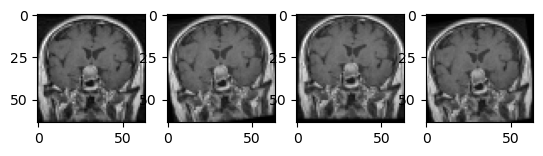

In [108]:
fig,axes = plt.subplots(1, 4)
for i in range(4):
    axes[i].imshow(block_reduce(data['pt'][827*i+3][0], (8,8), np.average), cmap='gray')

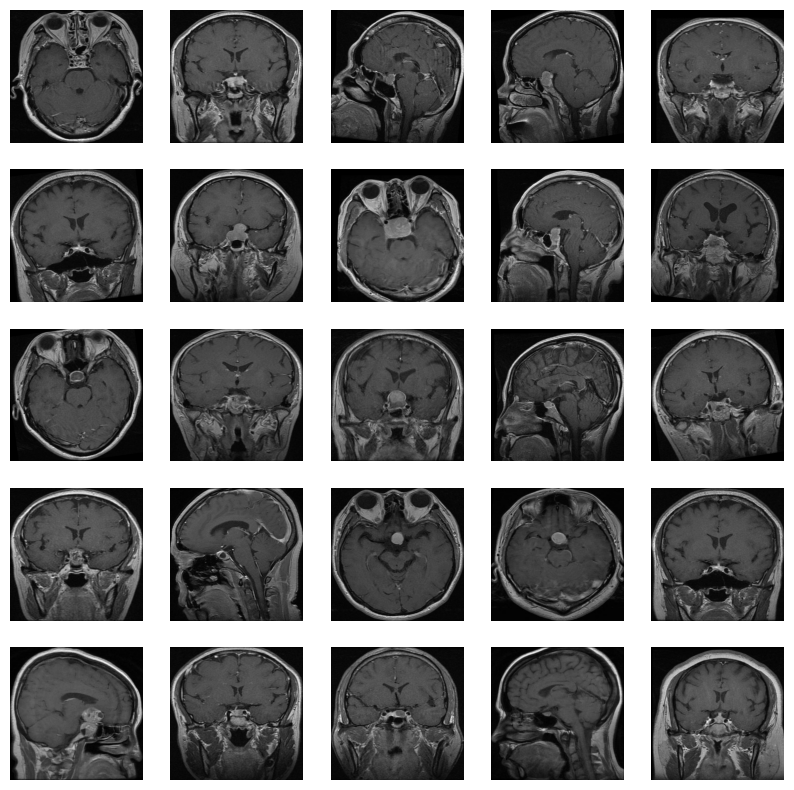

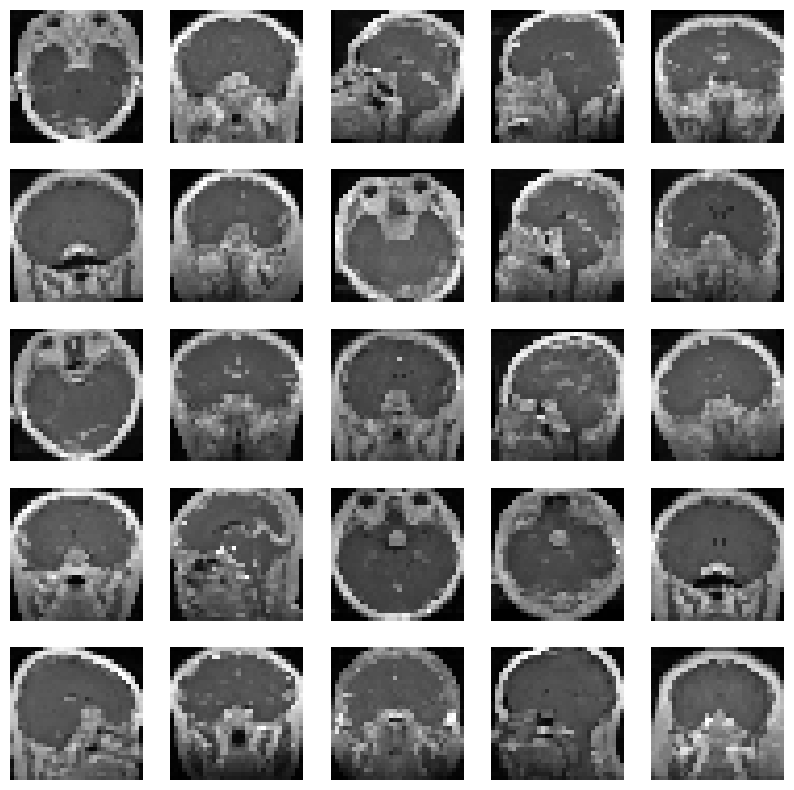

In [32]:
imgtable = imgshow5x5(list(map(lambda x: x[0], data['pt'])))
pooled = [block_reduce(np.asarray(imgtable[i]), (16, 16), np.max) for i in range(25)]
_ = imgshow5x5(pooled, order=list(range(25)))

0.9139606495047976


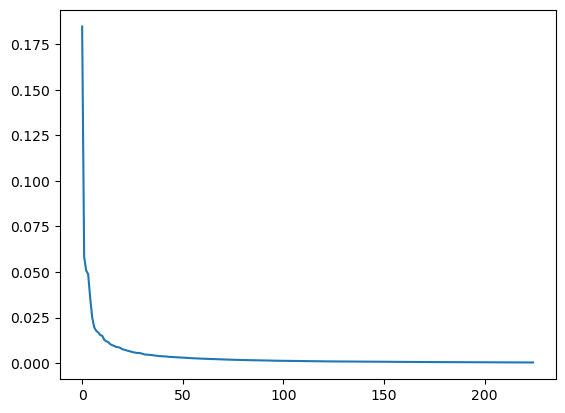

In [109]:
all_pooled = []; all_y = []; i = 0; kpool = 16; output = []
for k in data.keys():
    data_len = len(data[k])
    all_pooled += [block_reduce(data[k][i][0], (kpool, kpool), np.average).reshape((512//kpool) ** 2) for i in range(data_len)]
    # all_pooled += [data[k][i][0].reshape(512 ** 2) for i in range(data_len)]
    all_y += [i for _ in range(data_len)]
    i += 1

# for i in range(len(all_pooled)):
#     output.append(all_pooled[i] / np.max(all_pooled[i]))
output = all_pooled

# for i in range(len(output)//2):
#     output.append(output[i][::-1])
#     all_y.append(all_y[i])

pca = sklearn.decomposition.PCA(n_components=225)
pca.fit(output)
print(np.sum(pca.explained_variance_ratio_))
plt.plot(pca.explained_variance_ratio_)
output = pca.transform(output)

# ind = 0
# for k in data.keys():
#     data_len = len(data[k])
#     for i in range(data_len):
#         all_pooled[ind] = np.append(all_pooled[ind], data[k][i][2])
#         ind += 1


In [125]:
seed = np.random.randint(0, 100000)
X_train, X_test, y_train, y_test = \
sklearn.model_selection.train_test_split(output, all_y, test_size=0.1, shuffle=True, random_state=seed)
model = sklearn.svm.SVC(C=1.0)  # .914
#model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1, p=1)  # .912
#model = sklearn.ensemble.RandomForestClassifier(n_estimators=400, min_samples_split=4)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(sklearn.metrics.accuracy_score(y_pred, y_test))

0.8876306620209059


In [ ]:
model = sklearn.ensemble.RandomForestClassifier()
param_grid = {'n_estimators':[200, 300, 500], 'min_samples_split':[2,5,10]}
grid_search = sklearn.model_selection.GridSearchCV(model, param_grid, cv=4, scoring='accuracy')

grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print("최적 하이퍼파라미터: ", grid_search.best_params_)
print("최적 모델의 정확도: ", grid_search.best_score_)

# 최적 모델로 예측
y_pred = grid_search.best_estimator_.predict(X_test)

# 성능 평가
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
print("테스트 세트 정확도: ", accuracy)

최적 하이퍼파라미터:  {'min_samples_split': 2, 'n_estimators': 500}
최적 모델의 정확도:  0.8846281712967773
테스트 세트 정확도:  0.9070847851335656
